## Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,RandomizedSearchCV,KFold
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_curve, roc_auc_score
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

In [162]:
train_set = pd.read_csv('adult_train.csv')
train_set=pd.DataFrame(train_set)
train_set.head(2)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,class
0,2,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,1,0,2,United-States,<=50K
1,3,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,0,United-States,<=50K


In [163]:
train_set.shape

(48842, 15)

In [164]:
train_set.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capitalgain', 'capitalloss', 'hoursperweek', 'native-country',
       'class'],
      dtype='object')

In [165]:
col_name=["age", "workclass", "fnlwgt", "education", "education-num",
          "marital-status", "occupation", "relationship", "race", "sex",
          "capitalgain", "capitalloss", "hoursperweek", "native-country","class"]

In [166]:
test_set = pd.read_csv('adult_test.csv',names=col_name)
test_set=pd.DataFrame(test_set,)
test_set.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,class
0,|1x3 Cross validator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.


* Removing NaN values from the first row of the Test Set

In [167]:
test_set.drop([0],0,inplace=True)

In [168]:
test_set.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,class
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.
5,18,?,103497.0,Some-college,10.0,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K.


## EDA

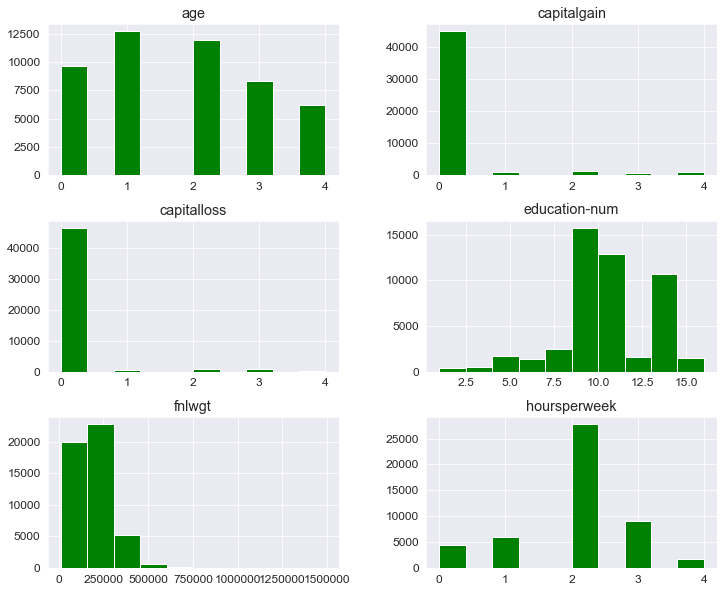

In [208]:
plt.rcParams['font.size'] = 12
train_sel = train_set.select_dtypes(include=['int64', 'float64']).columns
subset = train_set[train_sel]
subset.hist(figsize=(12,10),color='green')
plt.show()

In [169]:
train_cat = train_set.select_dtypes(include=['object'])
train_cat.columns

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country', 'class'],
      dtype='object')

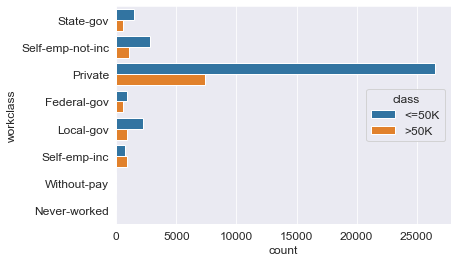

In [209]:
sns.countplot(y='workclass', hue='class', data = train_cat)
plt.show()

In [171]:
len(train_set),len(test_set)

(48842, 16281)

In [172]:
data = pd.concat([train_set,test_set],0).copy()

In [173]:
data.describe()

,fnlwgt,education-num,capitalgain,capitalloss,hoursperweek
count,6.512300e+04,65123.000000,65123.000000,65123.000000,65123.000000
mean,1.896070e+05,10.076793,270.630668,22.061361,11.561230
std,1.056310e+05,2.570098,3820.729852,205.103343,17.793856
min,1.228500e+04,1.000000,0.000000,0.000000,0.000000
25%,1.173660e+05,9.000000,0.000000,0.000000,2.000000
50%,1.780330e+05,10.000000,0.000000,0.000000,2.000000
75%,2.378650e+05,12.000000,0.000000,0.000000,4.000000
max,1.490400e+06,16.000000,99999.000000,3770.000000,99.000000


In [174]:
dict_class={'<=50K':0,' <=50K.':0,'>50K':1,' >50K.':1}

In [175]:
data['class']=data['class'].map(dict_class)
data.head(2)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,class
0,2,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,1.0,0.0,2.0,United-States,0
1,3,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,0.0,United-States,0


In [176]:
categorical_cols = ['workclass', 'marital-status', 'relationship', 'sex','race',
                    'native-country','education','occupation'] 

* As here the names of columns for Train & Test are different so,using mapping to make them similar

In [177]:
dict = {' Private':'Private','Private':'Private',' Local-gov':'Local-gov','Local-gov':'Local-gov',
        ' State-gov':'State-gov','State-gov':'State-gov',' Self-emp-inc':'Self-emp-inc','Self-emp-inc':'Self-emp-inc',
        ' Without-pay':'Without-pay','Without-pay':'Without-pay',' Never-worked':'Never-worked',
        ' Self-emp-not-inc':'Self-emp-not-inc','Self-emp-not-inc':'Self-emp-not-inc',
        ' Federal-gov':'Federal-gov','Federal-gov':'Federal-gov', ' ?':'?'}

In [178]:
data['workclass']=data['workclass'].map(dict)

In [179]:
data['marital-status'].unique()

array(['Never-married', 'Married-civ-spouse', 'Divorced',
       'Married-spouse-absent', 'Separated', 'Married-AF-spouse',
       'Widowed', ' Never-married', ' Married-civ-spouse', ' Widowed',
       ' Divorced', ' Separated', ' Married-spouse-absent',
       ' Married-AF-spouse'], dtype=object)

In [180]:
dict1 = {'Never-married':'Never-married',' Never-married':'Never-married','Married-civ-spouse':'Married-civ-spouse',
       ' Married-civ-spouse':'Married-civ-spouse','Divorced':'Divorced',' Divorced':'Divorced',
        'Married-spouse-absent':'Married-spouse-absent',' Married-spouse-absent':'Married-spouse-absent',
        'Separated':'Separated',' Separated':'Separated','Married-AF-spouse':'Married-AF-spouse',
        ' Married-AF-spouse':'Married-AF-spouse','Widowed':'Widowed',' Widowed':'Widowed'}

In [181]:
data['marital-status']=data['marital-status'].map(dict1)

In [182]:
dict2={'Not-in-family':'Not-in-family',' Not-in-family':'Not-in-family','Husband':'Husband',' Husband':'Husband',
      'Wife':'Wife',' Wife':'Wife','Own-child':'Own-child',' Own-child':'Own-child','Unmarried':'Unmarried',
      ' Unmarried':'Unmarried','Other-relative':'Other-relative',' Other-relative':'Other-relative'}

In [183]:
data['relationship']=data['relationship'].map(dict2)

In [184]:
data['sex'].unique()

array(['Male', 'Female', ' Male', ' Female'], dtype=object)

In [185]:
dict3={'Male':'Male',' Male':'Male','Female':'Female',' Female':'Female'}
data['sex']=data['sex'].map(dict3)

In [186]:
data['race'].unique()

array(['White', 'Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo',
       'Other', ' Black', ' White', ' Asian-Pac-Islander', ' Other',
       ' Amer-Indian-Eskimo'], dtype=object)

In [187]:
dict4={'White':'White',' White':'White','Black':'Black',' Black':'Black','Asian-Pac-Islander':'Asian-Pac-Islander',
      ' Asian-Pac-Islander':'Asian-Pac-Islander','Amer-Indian-Eskimo':'Amer-Indian-Eskimo',
      ' Amer-Indian-Eskimo':'Amer-Indian-Eskimo',' Other':'Other','Other':'Other'}

In [188]:
data['race']=data['race'].map(dict4)

In [189]:
data['native-country'].unique()

array(['United-States', 'Cuba', 'Jamaica', 'India', nan, 'Mexico',
       'South', 'Puerto-Rico', 'Honduras', 'England', 'Canada', 'Germany',
       'Iran', 'Philippines', 'Italy', 'Poland', 'Columbia', 'Cambodia',
       'Thailand', 'Ecuador', 'Laos', 'Taiwan', 'Haiti', 'Portugal',
       'Dominican-Republic', 'El-Salvador', 'France', 'Guatemala',
       'China', 'Japan', 'Yugoslavia', 'Peru',
       'Outlying-US(Guam-USVI-etc)', 'Scotland', 'Trinadad&Tobago',
       'Greece', 'Nicaragua', 'Vietnam', 'Hong', 'Ireland', 'Hungary',
       'Holand-Netherlands', ' United-States', ' ?', ' Peru',
       ' Guatemala', ' Mexico', ' Dominican-Republic', ' Ireland',
       ' Germany', ' Philippines', ' Thailand', ' Haiti', ' El-Salvador',
       ' Puerto-Rico', ' Vietnam', ' South', ' Columbia', ' Japan',
       ' India', ' Cambodia', ' Poland', ' Laos', ' England', ' Cuba',
       ' Taiwan', ' Italy', ' Canada', ' Portugal', ' China',
       ' Nicaragua', ' Honduras', ' Iran', ' Scotland', ' J

In [190]:
dict5={'United-States':'United-States',' United-States':'United-States','Cuba':'Cuba',' Cuba':'Cuba','Jamaica':'Jamaica',
      ' Jamaica':'Jamaica','India':'India',' India':'India','Mexico':'Mexico',' Mexico':'Mexico',
      'Puerto-Rico':'Puerto-Rico',' Puerto-Rico':'Puerto-Rico','Honduras':'Honduras',' Honduras':'Honduras',
      'England':'England',' England':'England','Canada':'Canada',' Canada':'Canada','Germany':'Germany',
      ' Germany':'Germany','Iran':'Iran',' Iran':'Iran','Philippines':'Philippines',' Philippines':'Philippines',
      'Poland':'Poland',' Poland':'Poland','Columbia':'Columbia',' Columbia':'Columbia','Thailand':'Thailand',
      ' Thailand':'Thailand','Ecuador':'Ecuador',' Ecuador':'Ecuador','Laos':'Laos',' Laos':'Laos',
      'Taiwan':'Taiwan',' Taiwan':'Taiwan','Haiti':'Haiti',' Haiti':'Haiti','Portugal':'Portugal',
      ' Portugal':'Portugal','Dominican-Republic':'Dominican-Republic',' Dominican-Republic':'Dominican-Republic',
      'El-Salvador':'El-Salvador',' El-Salvador':'El-Salvador','France':'France',' France':'France',
      'Guatemala':'Guatemala',' Guatemala':'Guatemala','Italy':'Italy',' Italy':'Italy','China':'China',
       ' China':'China','South':'South',' South':'South',' Japan':'Japan','Japan':'Japan','Cambodia':'Cambodia',
      ' Cambodia':'Cambodia','Greece':'Greece',' Greece':'Greece','Nicaragua':'Nicaragua',' Nicaragua':'Nicaragua',
      'Trinadad&Tobago':'Trinadad&Tobago',' Trinadad&Tobago':'Trinadad&Tobago',
       'Outlying-US(Guam-USVI-etc)':'Outlying-US(Guam-USVI-etc)',' Outlying-US(Guam-USVI-etc)':'Outlying-US(Guam-USVI-etc)',
       'Yugoslavia':'Yugoslavia',' Yugoslavia':'Yugoslavia','Peru':'Peru',' Peru':'Peru','?':'?',' ?':'?',
      'Hong':'Hong',' Hong':'Hong','Vietnam':'Vietnam',' Vietnam':'Vietnam','Nicaragua':'Nicaragua',
      ' Nicaragua':'Nicaragua','Hungary':'Hungary',' Hungary':'Hungary','Hong':'Hong',' Hong':'Hong',
      'Ireland':'Ireland',' Ireland':'ireland','Scotland':'Scotland',' Scotland':'Scotland',
       'Holand-Netherlands':'Holand-Netherlands'}

In [191]:
data['native-country']=data['native-country'].map(dict5)

In [192]:
data['education'].unique()

array(['Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college',
       'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school',
       '5th-6th', '10th', '1st-4th', 'Preschool', '12th', ' 11th',
       ' HS-grad', ' Assoc-acdm', ' Some-college', ' 10th',
       ' Prof-school', ' 7th-8th', ' Bachelors', ' Masters', ' Doctorate',
       ' 5th-6th', ' Assoc-voc', ' 9th', ' 12th', ' 1st-4th',
       ' Preschool'], dtype=object)

In [193]:
dict6={'Bachelors':'Bachelors',' Bachelors':'Bachelors','HS-grad':'HS-grad',' HS-grad':'HS-grad','11th':'11th',
      ' 11th':'11th','Masters':'Masters',' Masters':'Masters','9th':'9th',' 9th':'9th','10th':'10th',
      ' 10th':'10th','Some-college':'Some-college',' Some-college':'Some-college','Assoc-acdm':'Assoc-acdm',
      ' Assoc-acdm':'Assoc-acdm','7th-8th':'7th-8th',' 7th-8th':'7th-8th','Doctorate':'Doctorate',
      ' Doctorate':'Doctorate','Assoc-voc':'Assoc-voc',' Assoc-voc':'Assoc-voc','Prof-school':'Prof-school',
      ' Prof-school':'Prof-school','5th-6th':'5th-6th',' 5th-6th':'5th-6th','Preschool':'Preschool',
      ' Preschool':'Preschool','12th':'12th',' 12th':'12th','1st-4th':'1st-4th',' 1st-4th':'1st-4th'}

In [194]:
data['education']=data['education'].map(dict6)

In [195]:
data['occupation'].unique()

array(['Adm-clerical', 'Exec-managerial', 'Handlers-cleaners',
       'Prof-specialty', 'Other-service', 'Sales', 'Craft-repair',
       'Transport-moving', 'Farming-fishing', 'Machine-op-inspct',
       'Tech-support', nan, 'Protective-serv', 'Armed-Forces',
       'Priv-house-serv', ' Machine-op-inspct', ' Farming-fishing',
       ' Protective-serv', ' ?', ' Other-service', ' Prof-specialty',
       ' Craft-repair', ' Adm-clerical', ' Exec-managerial',
       ' Tech-support', ' Sales', ' Priv-house-serv', ' Transport-moving',
       ' Handlers-cleaners', ' Armed-Forces'], dtype=object)

In [196]:
dict7={'Adm-clerical':'Adm-clerical',' Adm-clerical':'Adm-clerical','Exec-managerial':'Exec-managerial',
       ' Exec-managerial':'Exec-managerial','Handlers-cleaners':'Handlers-cleaners',' Handlers-cleaners':'Handlers-cleaners',
       'Prof-specialty':'Prof-specialty',' Prof-specialty':'Prof-specialty','Other-service':'Other-service',
       ' Other-service':'Other-service','Sales':'Sales',' Sales':'Sales','Transport-moving':'Transport-moving',
       ' Transport-moving':'Transport-moving','Farming-fishing':'Farming-fishing',' Farming-fishing':'Farming-fishing',
       'Machine-op-inspct':'Machine-op-inspct',' Machine-op-inspct':'Machine-op-inspct','Tech-support':'Tech-support',
      ' Tech-support':'Tech-support','Craft-repair':'Craft-repair',' Craft-repair':'Craft-repair',
       'Protective-serv':'Protective-serv',' Protective-serv':'Protective-serv','Armed-Forces':'Armed-Forces',
       ' Armed-Forces':'Armed-Forces','Priv-house-serv':'Priv-house-serv',' Priv-house-serv':'Priv-house-serv',' ?':'?'}

In [197]:
data['occupation']=data['occupation'].map(dict7)

In [198]:
train = data[:48842]
test=data[48842:]

In [199]:
test.reset_index(drop=True,inplace=True)

In [200]:
train.dropna(inplace=True)
test.dropna(inplace=True)

## One-hot Encoding with categorical columns

In [201]:
from sklearn.preprocessing import LabelEncoder

In [202]:
categorical_cols = ['workclass', 'marital-status', 'relationship', 'sex','race',
                    'native-country','education','occupation'] 
le = LabelEncoder()
train[categorical_cols] = train[categorical_cols].apply(lambda col: le.fit_transform(col))

In [203]:
categorical_cols = ['workclass', 'marital-status', 'relationship', 'sex','race',
                    'native-country','education','occupation'] 
le = LabelEncoder()
test[categorical_cols] = test[categorical_cols].apply(lambda col: le.fit_transform(col))

In [204]:
for col in train.columns:
    train[col] = train[col].apply(int)

In [205]:
for col in test.columns:
    test[col] = test[col].apply(int)

In [206]:
corr=train.corr()

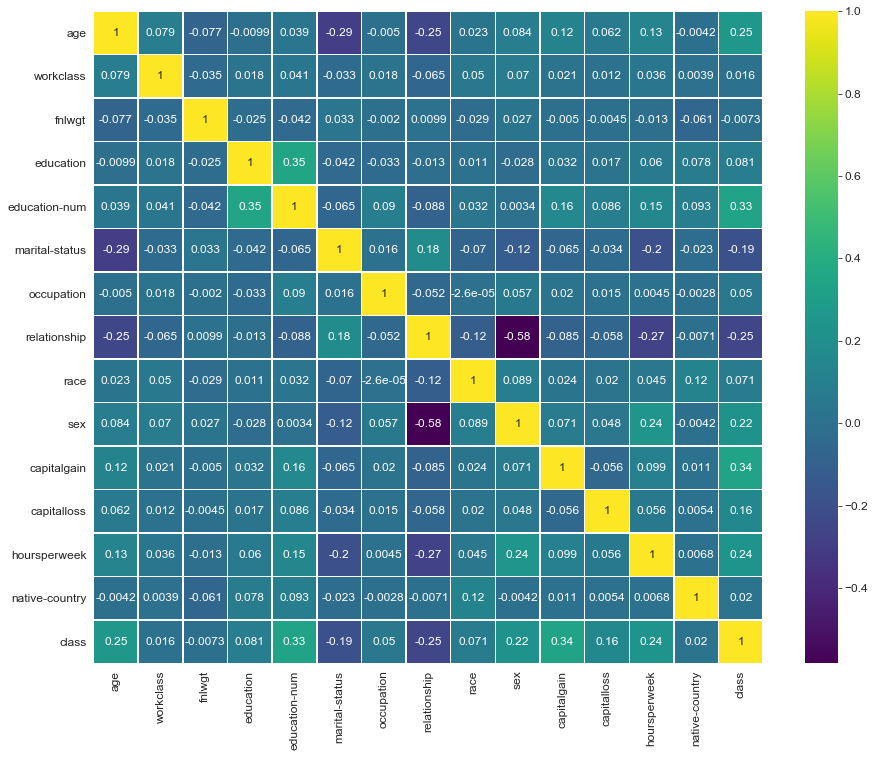

In [210]:
plt.figure(figsize=(15,12))
sns.heatmap(corr,annot=True,fmt='.2g',linewidths=0.5,cmap='viridis')
plt.show()

## Pearson-corelation 

In [211]:
pearson = corr[['class']].T.sort_values(by='class',ascending=False)

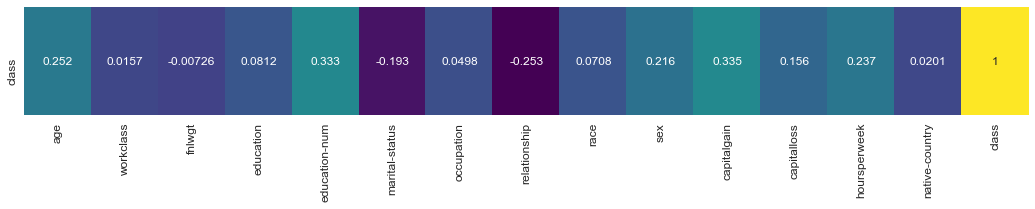

In [212]:
plt.figure(figsize=(18,2))
sns.heatmap(pearson,cmap='viridis',cbar=False,fmt='.3g',annot=True)
plt.show()

In [213]:
ytrain = train['class'].copy()
ytest = test['class'].copy()

In [214]:
del train['class'], test['class']

In [215]:
xtrain = train.copy()
xtest = test.copy()

In [216]:
del train,test,data

In [217]:
ytrain.shape,ytest.shape

((45222,), (16281,))

In [218]:
del xtrain['education-num'], xtest['education-num']

In [219]:
for col in xtrain.columns:
    xtrain[col] = xtrain[col].apply(lambda col : np.sqrt(col))

In [220]:
for col in xtest.columns:
    xtest[col] = xtest[col].apply(lambda col : np.sqrt(col))

In [221]:
xtest.head(2)

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country
0,5.000000,2.0,476.237336,1.000000,2.000000,2.645751,1.732051,1.414214,1.0,0.0,0.0,6.324555,6.082763
1,6.164414,2.0,299.689840,3.316625,1.414214,2.236068,0.000000,2.000000,1.0,0.0,0.0,7.071068,6.082763


In [222]:
xtrain.shape,xtest.shape,

((45222, 13), (16281, 13))

In [223]:
xtrain.shape,xtest.shape,ytrain.shape,ytest.shape

((45222, 13), (16281, 13), (45222,), (16281,))

In [224]:
X = pd.concat([xtrain,xtest]).copy()
y = pd.concat([ytrain,ytest]).copy()

In [225]:
X.shape

(61503, 13)

In [226]:
X = np.array(X)
X.shape

(61503, 13)

In [227]:
y = np.array(y)
y.shape

(61503,)

In [228]:
xtest = np.array(xtest)
xtest.shape

(16281, 13)

In [229]:
ytest = np.array(ytest)
ytest.shape

(16281,)

In [230]:
ytrain.shape,xtrain.shape

((45222,), (45222, 13))

## Xgboost Classifier

In [71]:
xgc = XGBClassifier(objective='binary:logitraw')

In [72]:
def Train_model(clf,X,y,rs=42):
    x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.20, random_state=rs,stratify=y)
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    score = accuracy_score(y_test,y_pred)
    print(f'random state:{rs} & Accuracy: {round((score*100),2)} %')

In [73]:
for i in range(20):
    Train_model(xgc,X,y,rs =i)

random state:0 & Accuracy: 85.34 %
random state:1 & Accuracy: 85.16 %
random state:2 & Accuracy: 85.33 %
random state:3 & Accuracy: 85.3 %
random state:4 & Accuracy: 85.49 %
random state:5 & Accuracy: 85.04 %
random state:6 & Accuracy: 85.39 %
random state:7 & Accuracy: 85.33 %
random state:8 & Accuracy: 85.73 %
random state:9 & Accuracy: 85.53 %
random state:10 & Accuracy: 85.59 %
random state:11 & Accuracy: 85.43 %
random state:12 & Accuracy: 85.34 %
random state:13 & Accuracy: 85.87 %
random state:14 & Accuracy: 85.16 %
random state:15 & Accuracy: 85.66 %
random state:16 & Accuracy: 85.25 %
random state:17 & Accuracy: 85.16 %
random state:18 & Accuracy: 85.27 %
random state:19 & Accuracy: 84.96 %


In [74]:
 Train_model(xgc,X,y,rs =13)

random state:13 & Accuracy: 85.87 %


## Random_Search CV

In [77]:
random_grid = {
    'booster': ['gbtree', 'dart'],
    'max_depth' : range(2,32,2),
    'max_delta_step' : range(2,20,2),
    'n_estimators': range(10,100,20),
    'learning_rate' : [0.1,0.01,0.001],
    'random_state':[15]}

In [78]:
random_search = RandomizedSearchCV(estimator = xgc,param_distributions = random_grid, cv = 5,n_jobs = -1)

In [79]:
random_search.fit(X,y)
best_parameters = random_search.best_params_
print(best_parameters)

{'random_state': 15, 'n_estimators': 90, 'max_depth': 26, 'max_delta_step': 2, 'learning_rate': 0.1, 'booster': 'dart'}


In [80]:
xgc = XGBClassifier(objective='binary:logitraw',booster = 'dart', max_depth = 26, max_delta_step = 2, 
                             n_estimators = 90, learning_rate = 0.1,random_state = 15)

## K-FOLD

In [81]:
def CV_train(clf,x,y,n=5):
    kf = KFold(n_splits=n) 
    kf.get_n_splits(x) 

    accu = []
    for train_index, test_index in kf.split(x):
        xtrain, xtest = x[train_index], x[test_index]
        ytrain,ytest = y[train_index],y[test_index]
        clf.fit(xtrain,ytrain)
        pred = clf.predict(xtest)
        acc = accuracy_score(pred,ytest)
        accu.append(acc)
    prediction = clf.predict(x)
    ac = accuracy_score(prediction,y)
    print(f"| CV: {n} | Mean Accuracy:{round(np.mean(accu)*100,2)}% | Over all Accuracy:{round(ac*100,2)}% |")
    return clf

In [82]:
for i in range(4,16):
    model = CV_train(xgc,X,y,n=i)

| CV: 4 | Mean Accuracy:84.04% | Over all Accuracy:93.66% |
| CV: 5 | Mean Accuracy:84.62% | Over all Accuracy:94.71% |
| CV: 6 | Mean Accuracy:84.62% | Over all Accuracy:95.55% |
| CV: 7 | Mean Accuracy:84.66% | Over all Accuracy:95.63% |
| CV: 8 | Mean Accuracy:84.58% | Over all Accuracy:95.91% |
| CV: 9 | Mean Accuracy:84.74% | Over all Accuracy:96.14% |
| CV: 10 | Mean Accuracy:84.73% | Over all Accuracy:96.21% |
| CV: 11 | Mean Accuracy:84.77% | Over all Accuracy:96.37% |
| CV: 12 | Mean Accuracy:84.77% | Over all Accuracy:96.37% |
| CV: 13 | Mean Accuracy:84.77% | Over all Accuracy:96.39% |
| CV: 14 | Mean Accuracy:84.77% | Over all Accuracy:96.6% |
| CV: 15 | Mean Accuracy:84.78% | Over all Accuracy:96.7% |


In [82]:
model = CV_train(xgc,X,y,n=13)

| CV: 13 | Mean Accuracy:84.77% | Over all Accuracy:96.39% |


In [83]:
y_pred = model.predict(xtest)

In [84]:
pred = model.predict(xtest)

In [85]:
acu = accuracy_score(y_pred ,ytest)
print("Test Accuracy from model->'XGB' with CV:",round(acu*100,2),'%')

Test Accuracy from model->'XGB' with CV: 95.57 %


### Loading the model..

In [3]:
import pickle

In [87]:
pickle.dump(model,open('model.pickle','wb'))

In [5]:
model=pickle.load(open('model.pickle','rb'))

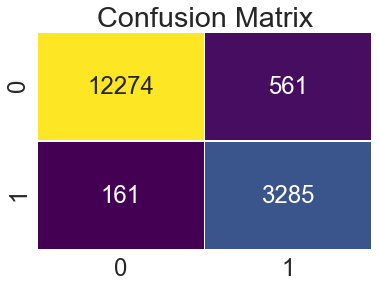

In [89]:
confus = confusion_matrix(y_pred,ytest)
plt.rcParams['font.size'] = 24
sns.heatmap(confus,annot=True,cbar=False,cmap='viridis',linewidths=0.5,fmt='.6g')
plt.title('Confusion Matrix')
plt.show()

In [90]:
TP = confus[0][0]
TP

12274

In [91]:
TN = confus[1][1]
TN

3285

In [92]:
FP = confus[0][1]
FP

561

In [93]:
FN = confus[1][0]
FN

161

In [94]:
accuracy = (TP+TN)/(TP+TN+FN+FP)
print("ACCURACY:",round(accuracy*100,2),'%')

ACCURACY: 95.57 %


In [95]:
precision = TP/(TP+FP)
print('PRECISION IS:',round(precision,2))

PRECISION IS: 0.96


In [96]:
recall = TP/(TP+FN)
print('RECALL IS:',round(recall,2))

RECALL IS: 0.99


In [97]:
F1_Score = 2*(recall * precision) / (recall + precision)
print("F1_Score is:",round(F1_Score,2))

F1_Score is: 0.97


In [98]:
auc = roc_auc_score(ytest, y_pred)
print("Area Under Curve:",round(auc,2))

Area Under Curve: 0.92


In [99]:
fpr, tpr, thresholds = roc_curve(ytest, y_pred)

## Auc-Roc Curve 

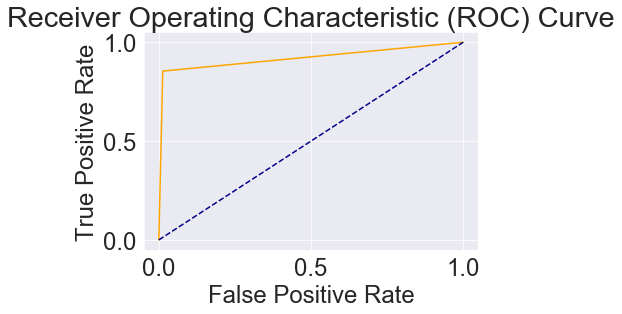

In [100]:
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (area = %0.1f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

### prediction for any input values

In [101]:
dic = {0:'Less or Equal to Rs.50k',1:'Grater Than Rs.50k'}
dic

{0: 'Less or Equal to Rs.50k', 1: 'Grater Than Rs.50k'}

In [102]:
xtrain.tail(2)

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country
48840,1.414214,1.414214,289.639431,3.0,0.000000,0.000000,1.732051,1.0,1.0,1.414214,0.0,1.414214,6.164414
48841,1.000000,1.732051,426.788004,3.0,1.414214,1.732051,0.000000,2.0,1.0,0.000000,0.0,1.732051,6.164414


**assign any values to the following parameters** 

In [248]:
age = 1.414214
workclass = 1.732051
fnlwgt = 289.639431
education = 8
marital_status = 4
occupation = 5
relationship = 3
race = 1
sex = 1
capitalgain = 0
capitalloss = 0
hoursperweek = 3 
native_country = 6.164414

input_data =[age,workclass,fnlwgt,education,marital_status,occupation,relationship,
             race,sex,capitalgain,capitalloss,hoursperweek,native_country]

**Prediction**

In [253]:
def prediction(input_data):
    inp = np.array(input_data)
    inp=inp.reshape(-1,13)
    pred = model.predict(inp)[0]
    return 'The Income Range is: '+str(dic[pred])
    

In [254]:
prediction(input_data)

'The Income Range is: Less or Equal to Rs.50k'

**_______________Thanks____**